### Tạo Dataset riêng

In [47]:
import  glob 
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm


In [22]:
# Cố định các chỉ số random để không thay đổi kết quả khi sử dụng vào project khác
torch.manual_seed(1234)     
np.random.seed(1234)
random.seed(1234)
# 2 thông số chạy trên GPU để cố định chạy nhiều lần cũng giống nhau
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Nếu cài đặt giữ kết quả như trên thì thời gian train sẽ lâu hơn so với train lại từ đầu

In [23]:
# Đưa ảnh vào và tiền xử lý ảnh
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # Tạo thêm dữ liệu resize
                transforms.RandomHorizontalFlip(),      # Tạo thêm dữ liệu quay
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

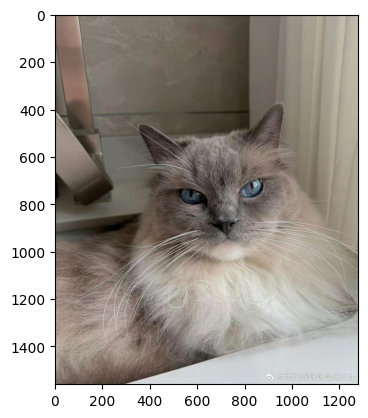

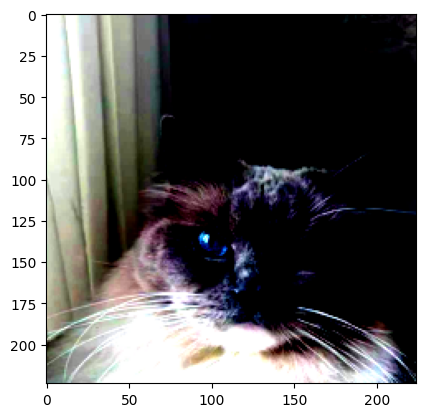

In [24]:
img_file_path = './data/cat.jpg'
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase="train")

# (channel, h, w) -> (h, w, channel) -> (0,1)
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [25]:
# Tao all duong link den anh
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")
    # print(target_path)
    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

In [26]:
path_list = make_datapath_list("train")

In [27]:
len(path_list)

243

In [28]:
path_list[2:10]

['./data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg']

In [29]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [30]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label

In [31]:
train_dataset = MyDataset(train_list, transform=ImageTransform(resize, mean, std), phase="train")
val_dataset = MyDataset(val_list, transform=ImageTransform(resize, mean, std), phase="val")

In [32]:
index = 0
print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

243
torch.Size([3, 224, 224])
0


## Tạo Dataloader  
Dataloader để load dữ liệu vào trong Network để train

In [33]:
# Dùng dataloader để đưa 1 nhóm ảnh vào trong mô hình
import torch.utils


batch_size = 4      # 1 lần train đc 4 ảnh

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}


In [34]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)

In [35]:
print(inputs.size())
print(labels)

torch.Size([4, 3, 224, 224])
tensor([0, 1, 0, 0])


## NETWORK


In [36]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
# print(net)
# Sửa lại đầu ra của ouput cuối cùng
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
# print(net)

# setting mode
net = net.train()


c:\Users\DUYEN\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DUYEN\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### loss

In [37]:
# Sửa lại đầu ra của ouput cuối cùng
criterior = nn.CrossEntropyLoss()

### optimizer

In [40]:
params_to_update = []
update_params_name = ["classifier.6.weight", "classifier.6.bias"]
for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0128,  0.0132,  0.0116,  ..., -0.0050,  0.0111,  0.0068],
        [ 0.0078, -0.0020, -0.0055,  ..., -0.0129, -0.0034, -0.0071]],
       requires_grad=True), Parameter containing:
tensor([ 0.0061, -0.0030], requires_grad=True)]


In [41]:
# # Khi muốn khai cập nhật toàn bộ mạng
# optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
# Khi muốn cập nhật tham số chỉ layer cuối
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)     

In [50]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))

        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double()/len(dataloader_dict[phase].dataset)
            
            print("{} Loss: {:.4f} Accuracy: {:.4f}".format(phase, epoch_loss, epoch_accuracy))
    

In [51]:
num_epochs = 10
train_model(net, dataloader_dict, criterior, optimizer, num_epochs)

Epoch 0/10


100%|██████████| 39/39 [00:18<00:00,  2.14it/s]


val Loss: 0.6927 Accuracy: 0.5752
Epoch 1/10


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Loss: 0.2299 Accuracy: 0.8971


100%|██████████| 39/39 [00:17<00:00,  2.26it/s]


val Loss: 0.1174 Accuracy: 0.9608
Epoch 2/10


100%|██████████| 61/61 [00:26<00:00,  2.28it/s]


train Loss: 0.1484 Accuracy: 0.9547


100%|██████████| 39/39 [00:16<00:00,  2.37it/s]


val Loss: 0.0775 Accuracy: 0.9673
Epoch 3/10


100%|██████████| 61/61 [00:26<00:00,  2.32it/s]


train Loss: 0.0812 Accuracy: 0.9671


100%|██████████| 39/39 [00:16<00:00,  2.30it/s]


val Loss: 0.1231 Accuracy: 0.9673
Epoch 4/10


100%|██████████| 61/61 [00:26<00:00,  2.34it/s]


train Loss: 0.1139 Accuracy: 0.9630


100%|██████████| 39/39 [00:16<00:00,  2.36it/s]


val Loss: 0.1074 Accuracy: 0.9608
Epoch 5/10


100%|██████████| 61/61 [00:26<00:00,  2.26it/s]


train Loss: 0.0333 Accuracy: 0.9918


100%|██████████| 39/39 [00:16<00:00,  2.35it/s]


val Loss: 0.1309 Accuracy: 0.9673
Epoch 6/10


100%|██████████| 61/61 [00:25<00:00,  2.35it/s]


train Loss: 0.1330 Accuracy: 0.9383


100%|██████████| 39/39 [00:16<00:00,  2.31it/s]


val Loss: 0.1345 Accuracy: 0.9542
Epoch 7/10


100%|██████████| 61/61 [00:25<00:00,  2.37it/s]


train Loss: 0.0937 Accuracy: 0.9588


100%|██████████| 39/39 [00:16<00:00,  2.39it/s]


val Loss: 0.1672 Accuracy: 0.9542
Epoch 8/10


100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


train Loss: 0.0419 Accuracy: 0.9794


100%|██████████| 39/39 [00:15<00:00,  2.44it/s]


val Loss: 0.1622 Accuracy: 0.9477
Epoch 9/10


100%|██████████| 61/61 [00:25<00:00,  2.43it/s]


train Loss: 0.0534 Accuracy: 0.9712


100%|██████████| 39/39 [00:16<00:00,  2.42it/s]

val Loss: 0.1564 Accuracy: 0.9542
